# 4. Дообучение модели учитывая мета информацию
- настройка классификатора под три класса
- разделение выборки train / valid
- модель дообучается на дополнительных данных о пациенте (мета информация)
- балансировка классов
- инференс модели и расчет **Accuracy** и **F1-score** (валидационная выборка)
- сохранение отчета метрик модели в csv
- применение **Grad-CAM** для визуализации областей внимания
- сравнение результатов с transfer

### 4.1. Обоснование использования мета-информации в дообучении модели

На предыдущих этапах мы построили и оптимизировали модель ResNet50 (Transfer + Optuna), которая обучалась исключительно на данных изображений рентгеновских снимков.
Несмотря на заметное улучшение качества по сравнению с базовой моделью, результаты показали, что модель все еще испытывает трудности в различении близких по визуальным признакам патологических классов (Lung Opacity и No Lung Opacity / Not Normal).

Чтобы повысить способность модели учитывать контекстные и клинические особенности пациентов, на данном этапе выполняется дообучение модели с использованием мета-информации (возраст, пол, проекция снимка и др.).

---

### 4.2. Идея подхода

Мета-признаки позволяют дополнить визуальные данные рентгеновского снимка дополнительным "смысловым контекстом":

- Возраст и пол - влияют на вероятность развития заболеваний (например, пневмонии у пожилых пациентов).

- Тип проекции (AP/PA) - определяет положение пациента и может влиять на видимость патологических зон.

- Spacing и разрешение снимка - влияют на контраст и детализацию областей интереса.

---

### 4.3. Техническая реализация

Для интеграции мета-информации используется многомодальный подход:

1. Изображение обрабатывается сверточной нейросетью (ResNet50), формируя вектор признаков изображения f_img.

2. Мета-признаки подаются в отдельную полносвязную подсеть (MLP), создавая вектор f_meta.

3. Оба вектора объединяются (конкатенируются) и поступают в финальный классификатор.

4. Такой подход позволяет модели одновременно учитывать визуальные и не-визуальные признаки пациента.

---

### 4.4. Цель этапа

- Оценить, повышает ли добавление мета-информации качество классификации.

- Проверить, какие классы выигрывают больше всего от дообучения на мета-признаках.

- Проанализировать поведение модели с помощью Grad-CAM, ROC-кривых и изучения ошибок (false positive / false negative).

- Сравнить новую модель (ResNet50 + Meta) с предыдущим результатом (ResNet50 Transfer + Optuna)
по ключевым метрикам (Accuracy, F1, Recall, Precision).

# Контроль запуска - первый запуск или нет

In [15]:
IS_FIRST_RUN = False # Если не хотите заново дообучать модели и вы скачали transfer_with_meta_resnet50_stage1_optuna.pth и resnet50_final.pth, можно оставить False.
SEED = 42

### Библиотеки

In [16]:
import sys
from pathlib import Path # удобная работа с путями (совместима с Windows/Linux)
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))
# ----------------------------техническая строка-------------------------------
import os, random                  # работа с путями и генераторами случайных чисел
import numpy as np                 # численные операции и работа с массивами
import torch                       # основной фреймворк PyTorch для нейронных сетей
import pandas as pd                # работа с табличными данными (DataFrame)
import matplotlib.pyplot as plt    # визуализация графиков и изображений
import torch.nn as nn              # модуль для построения нейросетей (Linear, Conv, и т.д.)
import json
from pathlib import Path           # удобная работа с путями (совместима с Windows/Linux)
from PIL import Image              # загрузка и обработка изображений (PNG, JPEG)
from pytorch_grad_cam import GradCAM # библиотека для использования GRAD-CAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms  # стандартные трансформации изображений (resize, flip, tensor)
from torch.utils.data import DataLoader  # классы для создания датасетов и загрузчиков данных
from sklearn.model_selection import train_test_split  # разбиение данных на train/val
from sklearn.metrics import (                         # расчет метрик качества
    classification_report,                            # табличный отчет по precision/recall/F1
    confusion_matrix,                                 # матрица ошибок
    ConfusionMatrixDisplay                            # визуализация матрицы ошибок
)

#src
from src.models import (
    ResNet50WithMeta,
    RSNADatasetWithMeta,
    compute_class_weights,
    predictions_on_validation_meta,
    model_fit_meta
)
from src.grad_cam import (
    _CamWrapper, 
    show_gradcam_png_grid
)
from src.metrics import (
    plot_metric_bars, 
    plot_metric_classes
)
from src.reports import save_model_report

In [17]:
# Проверяем параметры графической карты
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available!')
    print('Device name:', torch.cuda.get_device_name(0))
    print(f'Cuda version: {torch.version.cuda}')
else:
    print('CUDA is not available.')

CUDA is available!
Device name: NVIDIA GeForce RTX 3060 Laptop GPU
Cuda version: 12.4


In [18]:
# Воспроизводимость для KAGGLE / локально
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = False; torch.backends.cudnn.benchmark = True

# среда
ON_KAGGLE = Path('/kaggle/input').exists()

if ON_KAGGLE:
    BASE_DIR = Path('/kaggle/working')
    INPUT_DIR = Path('/kaggle/input/rsna-pneumonia-processed-png-meta')  # имя датасета на Kaggle
    PROC_DIR = INPUT_DIR
else:
    BASE_DIR = Path.cwd().parent
    PROC_DIR = BASE_DIR / 'data' / 'processed'

IMG_DIR = PROC_DIR / 'train_png'
META_DIR = PROC_DIR / 'meta_info_encoded.csv'

MODELS_DIR = BASE_DIR / 'models'; MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_FIG = BASE_DIR / 'reports' / 'figures'; REPORTS_FIG.mkdir(parents=True, exist_ok=True)
REPORTS_DIR = BASE_DIR / 'reports'

print('ON_KAGGLE:', ON_KAGGLE)
print('IMG_DIR:', IMG_DIR)
print('META_DIR:', META_DIR)

ON_KAGGLE: False
IMG_DIR: c:\Users\alexf\Desktop\rsna_pneumonia_project\data\processed\train_png
META_DIR: c:\Users\alexf\Desktop\rsna_pneumonia_project\data\processed\meta_info_encoded.csv


### Настройка классификатора под три класса

In [19]:
meta_info_encoded = pd.read_csv(META_DIR)

# трехклассовая цель создаем новый признак (закодированный)
CLASS_MAP = {'Normal':0, 'Lung Opacity':1, 'No Lung Opacity / Not Normal':2}
meta_info_encoded['class_id'] = meta_info_encoded['class'].map(CLASS_MAP)

meta_info_encoded.head(10)

,patientId,class,age,rows,cols,sex_F,sex_M,vp_AP,vp_PA,spacing_x,spacing_y,class_id
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,51.0,1024,1024,True,False,False,True,0.143000,0.143000,2
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,48.0,1024,1024,True,False,False,True,0.194311,0.194311,2
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,19.0,1024,1024,False,True,True,False,0.168000,0.168000,2
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,28.0,1024,1024,False,True,False,True,0.143000,0.143000,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,32.0,1024,1024,True,False,True,False,0.139000,0.139000,1
5,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal,54.0,1024,1024,False,True,True,False,0.139000,0.139000,2
6,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal,78.0,1024,1024,False,True,False,True,0.143000,0.143000,2
7,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,75.0,1024,1024,False,True,False,True,0.143000,0.143000,1
8,008c19e8-a820-403a-930a-bc74a4053664,No Lung Opacity / Not Normal,59.0,1024,1024,True,False,False,True,0.194311,0.194311,2
9,009482dc-3db5-48d4-8580-5c89c4f01334,Normal,63.0,1024,1024,False,True,False,True,0.143000,0.143000,0


### Разделение выборки train / valid и подготовка мета данных

In [20]:
train, valid = train_test_split(
    meta_info_encoded['patientId'],
    test_size=0.2, # 80/20
    random_state=SEED,
    stratify=meta_info_encoded['class_id'] # стратифицируем выборку (важно)
)

# Размеры выборок
df_train = meta_info_encoded[meta_info_encoded.patientId.isin(train)].reset_index(drop=True)
df_val = meta_info_encoded[meta_info_encoded.patientId.isin(valid)].reset_index(drop=True)

# Оставляем только некоторые признаки, т.к. есть сильные отрицательные корреляции (01_eda.ipynb)
# список метапризнаков, которые пойдет в MLP
META_COLS_CONT = ['age', 'spacing_x', 'spacing_y']
META_COLS_BIN  = ['sex_M', 'vp_AP']
META_COLS = META_COLS_CONT + META_COLS_BIN

# train-only mean/std для континуальных
meta_mean = df_train[META_COLS_CONT].mean()
meta_std  = df_train[META_COLS_CONT].std().replace(0, 1.0)

# сохраняем для воспроизводимости (используем и на val/test)
(Path(REPORTS_DIR)/'meta_norm.json').write_text(
    json.dumps({'mean':meta_mean.to_dict(), 'std':meta_std.to_dict()}, indent=2)
)

247

### Модель дообучается на дополнительных данных о пациенте (мета информация)

### Балансировка классов (идентична как и в transfer)

In [21]:
WEIGHTS = compute_class_weights(df_train, num_classes=3, device=device)

Class distribution (train): Counter({2: 9457, 0: 7081, 1: 4809})
Class weights: [0.31044284 0.45711073 0.2324464 ]


Загрузка json с лучшими параметрами

In [22]:
if IS_FIRST_RUN:
    best_json = REPORTS_DIR/'best_optuna_params.json'
    with open(best_json, 'r', encoding='utf-8') as f:
        best_payload = json.load(f)

    best = best_payload['best_params']
    config_name = best_payload.get('config_name', 'resnet50_tl_optuna')

    print('Loaded best params:', best)
    print('Config tag:', config_name)

    IMG_SIZE = int(best['img_size'])

    tfm_train = transforms.Compose([
        transforms.Grayscale(1),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85,1.0), ratio=(0.95,1.05)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(7),
        transforms.ColorJitter(brightness=0.10, contrast=0.10),
        transforms.ToTensor()
    ])
    tfm_val = transforms.Compose([
        transforms.Grayscale(1),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])

    ds_train = RSNADatasetWithMeta(df_train, IMG_DIR, tfm_train, META_COLS_CONT, META_COLS_BIN, meta_mean, meta_std)
    ds_val = RSNADatasetWithMeta(df_val, IMG_DIR, tfm_val, META_COLS_CONT, META_COLS_BIN, meta_mean, meta_std)

    dl_tr = DataLoader(ds_train, batch_size=int(best['batch_size']), shuffle=True,  num_workers=0, pin_memory=True)
    dl_val = DataLoader(ds_val, batch_size=max(16, int(best['batch_size'])), shuffle=False, num_workers=0, pin_memory=True)

    print(f'Размеры датасетов: \nDataLoaderTrain: {len(dl_tr)} \nDataLoaderValid: {len(dl_val)}')

Дообучение модели + мета признаки с лучшими гиперпараметрами

In [23]:
EPOCS_STAGE_1 = 4
EPOCS_STAGE_2 = 6

meta_dim = len(META_COLS)

model = ResNet50WithMeta(n_classes=3, meta_dim=meta_dim, freeze_backbone=True).to(device)
criterion = nn.CrossEntropyLoss(weight=WEIGHTS)

if IS_FIRST_RUN:
    amp = (device.type=='cuda')
    scaler = torch.amp.GradScaler('cuda', enabled=amp)

    # Шаг 1: обучаем только meta-голову + финальный классификатор
    for n,p in model.named_parameters():
        p.requires_grad = False
    for n,p in model.named_parameters():
        if n.startswith('meta') or n.startswith('classifier'):
            p.requires_grad = True

    opt1 = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=float(best['lr_fc']), 
        weight_decay=float(best['weight_decay'])
    )

    ckpt1 = MODELS_DIR/'transfer_with_meta_resnet50_stage1_optuna.pth'

    best1 = model_fit_meta(model, 
                        scaler, 
                        opt1, 
                        criterion, 
                        dl_tr, 
                        dl_val, 
                        device, 
                        EPOCS_STAGE_1, 
                        ckpt1, 
                        amp
    )
    print('best F1 stage1:', best1)

    # Шаг 2: разморозка слоев по выбранной схеме
    print('Загружаем лучший чекпойнт Stage1 и настраиваем разморозку...')
    model.load_state_dict(torch.load(ckpt1, map_location=device))

    for _,p in model.named_parameters(): 
        p.requires_grad = False
    if best.get('unfreeze') == 'layer3+layer4': 
        model.unfreeze_layer3_4()
    else:                                       
        model.unfreeze_layer4()
    # плюс classifier и meta оставляем trainable
    for n,p in model.named_parameters():
        if n.startswith('meta') or n.startswith('classifier'):
            p.requires_grad = True

    opt2 = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=float(best['lr_ft']), 
        weight_decay=float(best['weight_decay'])
    )

    ckpt2 = MODELS_DIR/'resnet50_final.pth'

    best2 = model_fit_meta(model, 
                        scaler, 
                        opt2, 
                        criterion, 
                        dl_tr, 
                        dl_val, 
                        device, 
                        EPOCS_STAGE_2, 
                        ckpt2, 
                        amp
    )
    print('best F1 stage2:', best2)

### Инференс модели и расчет **Accuracy** и **F1-score** (валидационная выборка)

In [24]:
# Опять загружаем лучшие параметры для использования модели (только валидация)
best_json = REPORTS_DIR/'best_optuna_params.json'
with open(best_json, 'r', encoding='utf-8') as f:
    best_payload = json.load(f)

best = best_payload['best_params']
config_name = best_payload.get('config_name', 'resnet50_tl_optuna')

print('Loaded best params:', best)
print('Config tag:', config_name)

# Переопределяем глобальные tfm и DataLoader под лучшие гиперпараметры
IMG_SIZE = int(best['img_size'])

tfm_val = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

ds_val = RSNADatasetWithMeta(df_val, IMG_DIR, tfm_val, META_COLS_CONT, META_COLS_BIN, meta_mean, meta_std)
dl_val = DataLoader(ds_val, batch_size=max(16, int(best['batch_size'])), shuffle=False, num_workers=0, pin_memory=True)

# Загрузка лучшего чекпойнта
best_path = MODELS_DIR / 'resnet50_final.pth'  # из этапа финального обучения + meta с лучшими гиперпараметрами
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()  # режим эксплуатации модели

# Предсказания на валидации (y_true, y_pred, y_prob)
y_true, y_pred, y_prob = predictions_on_validation_meta(
    model_=model,
    device_=device,
    dl_va_=dl_val)

Loaded best params: {'img_size': 512, 'batch_size': 8, 'lr_fc': 0.0020292214181030924, 'lr_ft': 7.864557912273797e-05, 'weight_decay': 3.2161947858718945e-06, 'unfreeze': 'layer3+layer4', 'scheduler': 'none'}
Config tag: resnet50_tl_optuna_sz512_bs8_lrfc0.0020_lrft7.9e-05_wd3.2e-06_layer3+layer4_none


### Построение confusion matrix

                              precision    recall  f1-score   support

                      Normal     0.7819    0.8689    0.8231      1770
                Lung Opacity     0.7010    0.5436    0.6124      1203
No Lung Opacity / Not Normal     0.6996    0.7212    0.7103      2364

                    accuracy                         0.7302      5337
                   macro avg     0.7275    0.7113    0.7152      5337
                weighted avg     0.7272    0.7302    0.7256      5337



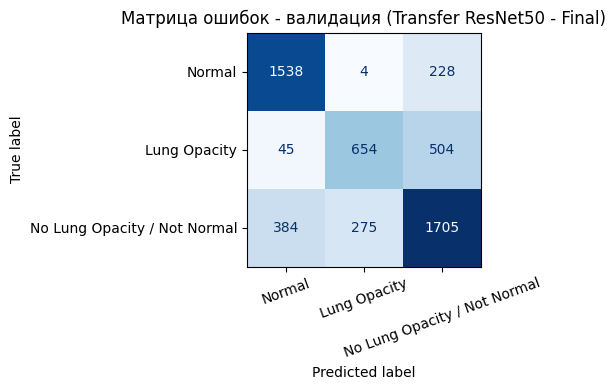

Матрица ошибок сохранена: c:\Users\alexf\Desktop\rsna_pneumonia_project\reports\figures\transfer_confusion_matrix_final.png


In [25]:
id_to_label = {0:'Normal', 1:'Lung Opacity', 2:'No Lung Opacity / Not Normal'}
target_names = [id_to_label[i] for i in sorted(id_to_label)]
fig_path = REPORTS_FIG / 'transfer_confusion_matrix_final.png'
REPORTS_FIG.mkdir(parents=True, exist_ok=True)

print(classification_report(
    y_true, 
    y_pred,
    target_names=target_names, 
    digits=4))

conf_matrix = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay(conf_matrix, display_labels=target_names).plot(
    ax=ax, 
    cmap='Blues',
    values_format='d',
    colorbar=False, 
    xticks_rotation=20
)
plt.title('Матрица ошибок - валидация (Transfer ResNet50 - Final)')
plt.tight_layout()
plt.savefig(fig_path, dpi=150)
plt.show()
print('Матрица ошибок сохранена:', fig_path)

### Cохранение отчета метрик модели в csv

In [26]:
# Сохраняем в основной CSV
REPORTS_DIR = REPORTS_FIG.parent  # 'reports'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
csv_path = REPORTS_DIR / 'final_metrics.csv'

num_epocs = EPOCS_STAGE_1 + EPOCS_STAGE_2

save_model_report(
    model_name='ResNet50Final',
    y_true=y_true,
    y_pred=y_pred,
    y_prob=y_prob,
    target_names=target_names,
    num_epocs=num_epocs,
    csv_path=csv_path
)

Сводные метрики сохранены в CSV: c:\Users\alexf\Desktop\rsna_pneumonia_project\reports\final_metrics.csv


### Применение **Grad-CAM** для визуализации областей внимания

In [27]:
# целевой слой (последний bottleneck у ResNet50)
target_layer = model.backbone.layer4[-1]
out_dir = REPORTS_FIG / 'gradcam_final'
out_dir.mkdir(parents=True, exist_ok=True)
n_show = min(6, len(ds_val))

model.eval()
wrapped = _CamWrapper(model)

with GradCAM(model=wrapped, target_layers=[target_layer]) as cam:
    for i in range(n_show):
        img, meta, y = ds_val[i]
        x_img  = img.unsqueeze(0).to(device).requires_grad_(True)
        x_meta = meta.unsqueeze(0).to(device)
        wrapped.set_meta(x_meta)

        with torch.no_grad():
            pred_cls = int(model(x_img, x_meta).argmax(1).item())

        grayscale_cam = cam(input_tensor=x_img, targets=[ClassifierOutputTarget(pred_cls)])[0]

        # Нормализация и RGB для оверлея
        base = img.squeeze().cpu().numpy()
        base = (base - base.min()) / (base.max() - base.min() + 1e-6)
        rgb_img = np.repeat(base[..., None], 3, axis=2)

        vis = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=0.65)

        pid = ds_val.df.iloc[i].patientId
        save_path = out_dir / f'{pid}_true{y}_pred{pred_cls}.png'
        Image.fromarray(vis).save(save_path)

    print('Снимки Grad-CAM (final) сохранены в:', out_dir)

Снимки Grad-CAM (final) сохранены в: c:\Users\alexf\Desktop\rsna_pneumonia_project\reports\figures\gradcam_final


### Выводим результаты

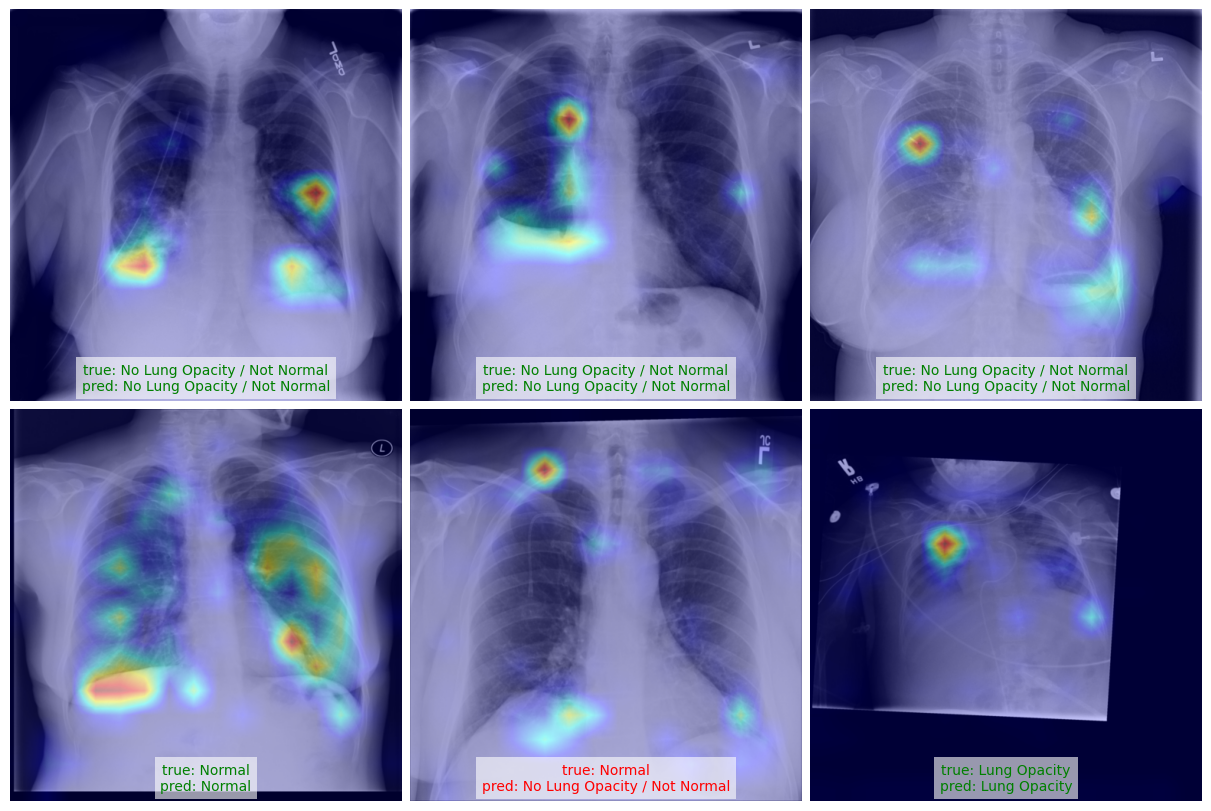

In [28]:
gradcam_dir = REPORTS_FIG / 'gradcam_final'
files = sorted(gradcam_dir.glob('*.png'))
id_to_label = {0:'Normal', 1:'Lung Opacity', 2:'No Lung Opacity / Not Normal'}

show_gradcam_png_grid(files, cols=3, id_to_label=id_to_label)

После добавления мета-признаков Grad-CAM показывает более локализованные и уверенные области внимания.
Это объясняется тем, что мета-информация (возраст, пол, проекция) влияет на распределение градиентов ошибки, что косвенно перестраивает фильтры CNN.
В результате модель меньше "сканирует" все изображение и сосредотачивается на типичных для класса областях, что повышает ее уверенность и интерпретируемость.

### Сравнение результатов с transfer

In [29]:
df_tr = pd.read_csv(REPORTS_DIR / 'transfer_optuna_metrics.csv')
df_final = pd.read_csv(REPORTS_DIR / 'final_metrics.csv')

# Добавим столбец 'model_pretty' для подписей на графиках
df_tr['model_pretty'] = 'ResNet50 (Transfer + Optuna)'
df_final['model_pretty']   = 'ResNet50 Final (Transfer + Optuna + Meta)'

# Объединяем
df_compare = pd.concat([df_tr, df_final], ignore_index=True)

# Для удобства переупорядочим колонки
cols = ['model_pretty', 'epocs', 'accuracy', 
        'f1_Normal','f1_macro', 'f1_weighted',
        'f1_Lung Opacity', 'f1_No Lung Opacity / Not Normal',
        'recall_Normal','recall_macro', 'recall_weighted',
        'recall_Lung Opacity', 'recall_No Lung Opacity / Not Normal',
        'roc_auc_ovr_macro','roc_auc_ovo_macro', 'pr_auc_macro']
df_compare = df_compare[cols]
display(df_compare)

,model_pretty,epocs,accuracy,f1_Normal,f1_macro,f1_weighted,f1_Lung Opacity,f1_No Lung Opacity / Not Normal,recall_Normal,recall_macro,recall_weighted,recall_Lung Opacity,recall_No Lung Opacity / Not Normal,roc_auc_ovr_macro,roc_auc_ovo_macro,pr_auc_macro
0,ResNet50 (Transfer + Optuna),10,0.720817,0.82764,0.714781,0.716067,0.651126,0.665576,0.903390,0.730238,0.720817,0.684954,0.602369,0.882712,0.882712,0.785894
1,ResNet50 Final (Transfer + Optuna + Meta),10,0.730185,0.82312,0.715249,0.725626,0.612360,0.710269,0.868927,0.711268,0.730185,0.543641,0.721235,0.882387,0.882387,0.788692


f1 и recall по классам

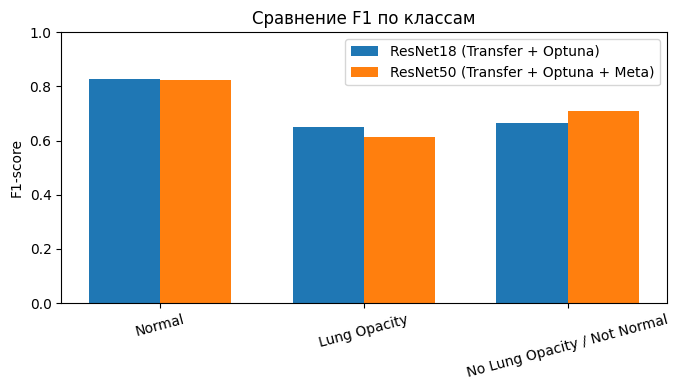

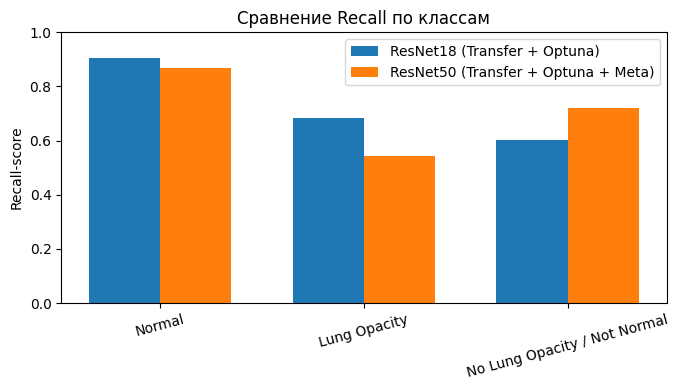

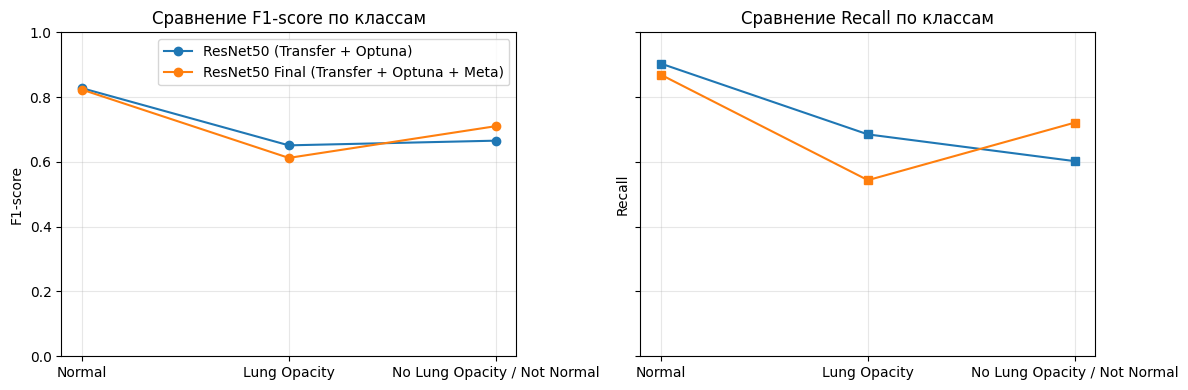

In [30]:
labels = ['Normal', 'Lung Opacity', 'No Lung Opacity / Not Normal']
model_names = ('ResNet18 (Transfer + Optuna)', 'ResNet50 (Transfer + Optuna + Meta)')

plot_metric_bars(df_tr, 
                 df_final, 
                 labels,
                 prefix='f1_', 
                 title='Сравнение F1 по классам', 
                 ylabel='F1-score',
                 model_names=model_names
)

plot_metric_bars(df_tr, 
                 df_final, 
                 labels,
                 prefix='recall_', 
                 title='Сравнение Recall по классам', 
                 ylabel='Recall-score',
                 model_names=model_names
)

plot_metric_classes(df_compare)

Обобщающие метрики качества улучшились.
1. Показатель F1-macro вырос с 0.715 -> 0.716, а F1-weighted - с 0.716 -> 0.726, что отражает повышение баланса между точностью и полнотой по всем классам.
Модель стала более «уверенной» в предсказаниях по трудным примерам, сохранив при этом устойчивость к переобучению.

2. Recall для патологий увеличился, в то время как для нормальных снимков наблюдается незначительное снижение. Это указывает на то, что модель стала чувствительнее к признакам заболевания, что крайне важно в медицинских сценариях, где ложное пропускание патологии (false negative) более критично, чем ложное срабатывание.

3. ROC-AUC (macro) остался на прежнем уровне (~0.883), что логично: добавление мета-признаков не изменяет глобальную способность модели различать классы, но улучшает качество распознавания в «пограничных» случаях, где решающее значение имеют контекстные признаки пациента.

4. PR-AUC (macro) увеличился с 0.786 -> 0.789, что говорит о повышении доверия модели к собственным вероятностным предсказаниям. Это особенно важно при работе с несбалансированными классами, где precision-recall метрики более показательны, чем ROC.

5. Анализ Grad-CAM показал, что после включения мета-информации изменился характер внимания модели: области активации стали более локализованными и осмысленными. Сеть меньше «сканирует» все изображение в поисках паттернов и чаще концентрируется на анатомически и клинически значимых участках (верхние и нижние доли легких, прикорневая область). Это указывает на повышение интерпретируемости и доверия к результатам модели.

6. Качественный анализ ошибок подтвердил, что основное улучшение достигается на сложных случаях классов Lung Opacity и Not Normal, где визуальные признаки могут быть неоднозначными. Мета-признаки позволяют корректировать решение модели, используя демографические и технические параметры снимка, тем самым снижая количество ложных классификаций.

### Как итог:

Добавление мета-информации в архитектуру ResNet50 позволило улучшить чувствительность модели к патологическим изменениям и повысить общую устойчивость классификации без потери калибровки вероятностей.
Модель стала более интерпретируемой, а результаты - более согласованными с клинической логикой анализа рентгенограмм.

Полученные результаты подтверждают целесообразность использования мета-признаков в медицинских задачах компьютерного зрения как эффективного способа повышения точности и надежности классификации.

Однако, для достижения более существенных результатов и устойчивого роста метрик, модели требуется значительно бОльший объем флюорографических снимков легких.
Текущий датасет из 26684 изображений является ограниченным для задач глубокого обучения такого уровня сложности.
Увеличение выборки, в частности за счет данных из разных источников и проекций, позволит модели лучше обобщать редкие патологические паттерны и снизить зависимость от специфики текущей выборки.

Таким образом, этап Transfer + Optuna + Meta можно считать успешно завершенным.